In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.ops import unary_union

In [3]:
# --- 1. Load borough boundaries ---
fp_boroughs = 'data/boundary_lines/district_borough_unitary_region.shp'
boroughs = gpd.read_file(fp_boroughs)

# Filter to Greater Manchester districts
gm_districts = [
    'Manchester District (B)',
    'Bury District (B)',
    'Oldham District (B)',
    'Rochdale District (B)',
    'Salford District (B)',
    'Trafford District (B)',
    'Stockport District (B)',
    'Tameside District (B)',
    'Bolton District (B)',
    'Wigan District (B)', 
]

gm_boroughs = boroughs[boroughs['NAME'].isin(gm_districts)]
gm_boroughs = gm_boroughs.to_crs(epsg=3857)  # Web Mercator for plotting with contextily

In [4]:
# --- 2. Load green spaces ---
fp_sd = 'data/greenspace_SD/SD_GreenspaceSite.shp'
fp_sj = 'data/greenspace_SJ/SJ_GreenspaceSite.shp'

gs_sd = gpd.read_file(fp_sd)
gs_sj = gpd.read_file(fp_sj)

green_spaces = gpd.GeoDataFrame(pd.concat([gs_sd, gs_sj], ignore_index=True))

# Filter to specific function types
function_types = [
    'Play Space',
    'Playing Field',
    'Public Park Or Garden',
    'Bowling Green',
    'Allotments Or Community Growing Spaces',
]

green_spaces = green_spaces[green_spaces['function'].isin(function_types)]

# Reproject to match boroughs CRS
green_spaces = green_spaces.to_crs(gm_boroughs.crs)

In [5]:
# --- 3. Spatial join: get green spaces inside Greater Manchester ---
gm_green_spaces = gpd.sjoin(green_spaces, gm_boroughs, predicate='intersects')

In [6]:
# --- 4. Compute union and bounding box for plotting ---
gm_union = unary_union(gm_boroughs.geometry)
bounds = gpd.GeoSeries(gm_union).bounds.iloc[0]  # minx, miny, maxx, maxy


xlim = (bounds['minx'], bounds['maxx'])
ylim = (bounds['miny'], bounds['maxy'])

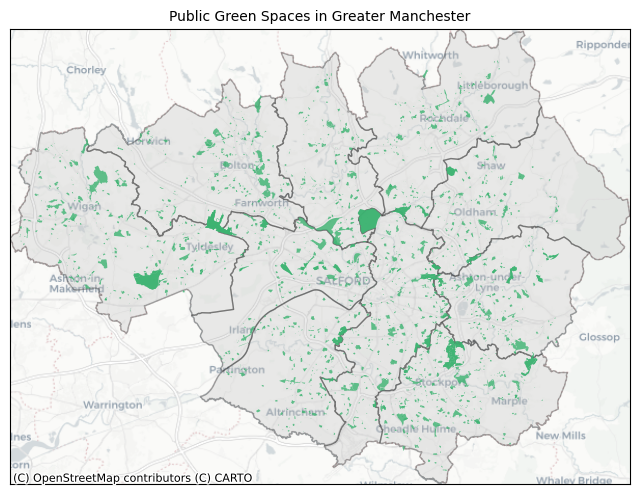

In [9]:
# --- 5. Plot map ---
fig, ax = plt.subplots(figsize=(8, 8))

# Boroughs
gm_boroughs.plot(ax=ax, alpha=0.3, edgecolor='black', facecolor='silver', linewidth=1)

# Green spaces
gm_green_spaces.plot(ax=ax, alpha=0.8, color='mediumseagreen', label='Green Open Spaces')

# Basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# Axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Clean axes
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# # Legend
# ax.legend()

plt.title("Public Green Spaces in Greater Manchester", fontsize=10)
plt.show()